In [15]:
import numpy as np
import joblib
from setfit import SetFitModel
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin
import pandas as pd
import json
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

#### Test Data -> annotated.json

In [16]:
class Preprocessing_JSON_annotated_Seniority:
    """
    Loads an annotated JSON file (list of persons, each a list of jobs).
    Keeps ONLY the latest ACTIVE job per person (by startDate).
    Returns:
      - self.X: pd.Series of cleaned positions (text)
      - self.y: pd.Series of raw string labels (seniority)  # NOT encoded
      - self.df: DataFrame with columns ["text", "label"]
    """

    def __init__(self, path: str):
        self.path = path
        self.df: pd.DataFrame | None = None
        self.X: pd.Series | None = None
        self.y: pd.Series | None = None

        self.read_json()

    @staticmethod
    def _parse_year_month(s):
        """Expects 'YYYY-MM' -> (year, month) or None."""
        if not isinstance(s, str) or len(s) < 7:
            return None
        try:
            year, month = s.split("-")
            return int(year), int(month)
        except Exception:
            return None

    @staticmethod
    def clean_text(text: str) -> str:
        return str(text).lower().strip().replace("-", " ").replace("/", " ")

    def read_json(self):
        with open(self.path, "r", encoding="utf-8") as f:
            data = json.load(f)

        rows = []

        for person_jobs in data:
            if not isinstance(person_jobs, list):
                continue

            active_jobs = []
            for job in person_jobs:
                if not isinstance(job, dict):
                    continue
                if job.get("status") != "ACTIVE":
                    continue

                start = self._parse_year_month(job.get("startDate"))
                if start is None:
                    continue

                active_jobs.append((start, job))

            if not active_jobs:
                continue

            _, job = max(active_jobs, key=lambda x: x[0])

            position = job.get("position")
            seniority = job.get("department")

            if not position or not seniority:
                continue

            rows.append(
                {"text": self.clean_text(position), "label": str(seniority)}
            )

        self.df = pd.DataFrame(rows)
        if self.df.empty:
            raise ValueError("No valid samples found in JSON")

        self.X = self.df["text"].astype(str)
        self.y = self.df["label"].astype(str)

        print(f"[JSON] Loaded {len(self.df)} samples from {self.path}")

In [17]:
data = Preprocessing_JSON_annotated_Seniority("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json")

X_texts = data.X.squeeze().astype(str).tolist()
y_true  = data.y.to_numpy(dtype=object)

encoder = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/encoder_department.joblib")

class_order = np.array(getattr(encoder, "classes_", None), dtype=object)
if class_order.size == 0:
    raise ValueError("Encoder does not provide 'classes_'. Provide class order explicitly.")

[JSON] Loaded 457 samples from /Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/data/linkedin-cvs-annotated.json


#### Pipeline

In [18]:
# Load BOW + Logistic Regression Model
bow_lr_model = joblib.load("/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/bow_department.joblib")

bow_lr_model

Pipeline(steps=[('bow', CountVectorizer(max_df=0.9, ngram_range=(1, 2))),
                ('ros', RandomOverSampler(random_state=123)),
                ('clf',
                 LogisticRegression(C=10, max_iter=2000, solver='liblinear'))])

In [19]:
# Huggingface Model
model_hf = SetFitModel.from_pretrained(
    "/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/department-classifier-v2",
    local_files_only=True
)

The tokenizer you are loading from '/Users/jonas/Documents/Master_Vorlesungen/Semester_02/Practical Data Science/Final/PDS_Final/models/department-classifier-v2' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


In [20]:
enc_order = list(encoder.classes_)
hf_labels = list(model_hf.labels)

idx = [hf_labels.index(c) for c in enc_order]

aligned_label_order = [hf_labels[i] for i in idx]
print("HF labels (original):", hf_labels)
print("HF labels (reordered):", aligned_label_order)
print("Encoder order:", enc_order)

assert aligned_label_order == enc_order, "Alignment failed: reordered HF labels != encoder order"


HF labels (original): ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
HF labels (reordered): ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
Encoder order: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']


In [21]:
def align_proba_to_class_order(model_hf, texts, class_order):
    """
    SetFit predict_proba columns are in model_hf.labels order.
    Reorder them to match class_order.
    """
    P = np.asarray(model_hf.predict_proba(texts))
    hf_labels = list(model_hf.labels)

    # map each class in class_order to its column index in SetFit output
    try:
        idx = [hf_labels.index(c) for c in class_order]
    except ValueError as e:
        missing = [c for c in class_order if c not in hf_labels]
        raise ValueError(f"SetFit model is missing labels: {missing}") from e

    return P[:, idx]


def soft_vote_predict_proba(model_bow, model_hf, texts, class_order, w_bow=0.2, w_hf=0.8):
    """
    Weighted soft-voting ensemble over class probabilities.
    Returns:
      - y_pred (string labels)
      - P_ens  (aligned probabilities in class_order)
    """
    texts = list(texts)

    P_bow = np.asarray(model_bow.predict_proba(texts))
    P_hf  = align_proba_to_class_order(model_hf, texts, class_order)

    if P_bow.shape != P_hf.shape:
        raise ValueError(f"Shape mismatch: P_bow {P_bow.shape} vs P_hf {P_hf.shape}")

    w_sum = (w_bow + w_hf)
    if w_sum <= 0:
        raise ValueError("Weights must sum to a positive number.")

    P_ens = (w_bow * P_bow + w_hf * P_hf) / w_sum
    y_pred = class_order[np.argmax(P_ens, axis=1)]
    return y_pred, P_ens


def evaluate(name, y_true, y_pred, labels):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"{name} Accuracy: {acc:.4f}")
    print(f"{name} Macro F1:  {f1m:.4f}")
    return acc, f1m

y_pred_hf = np.array(model_hf.predict(X_texts), dtype=object)
evaluate("SetFit", y_true, y_pred_hf, labels=class_order)

y_pred_ens, P_ens = soft_vote_predict_proba(
    bow_lr_model, model_hf, X_texts, class_order,
    w_bow=0.2, w_hf=0.8
)

evaluate("SoftVote", y_true, y_pred_ens, labels=class_order)

print("\nSoftVote classification report:")
print(classification_report(
    y_true, y_pred_ens,
    labels=class_order,
    target_names=class_order,
    zero_division=0
))

SetFit Accuracy: 0.7112
SetFit Macro F1:  0.5627
SoftVote Accuracy: 0.7177
SoftVote Macro F1:  0.5690

SoftVote classification report:
                        precision    recall  f1-score   support

        Administrative       0.50      0.30      0.38        10
  Business Development       0.67      0.25      0.36        16
            Consulting       0.64      0.59      0.62        27
      Customer Support       0.50      0.33      0.40         6
       Human Resources       0.69      0.56      0.62        16
Information Technology       0.70      0.58      0.63        52
             Marketing       0.58      0.37      0.45        19
                 Other       0.75      0.88      0.81       232
    Project Management       0.70      0.63      0.67        30
            Purchasing       0.47      0.75      0.58        12
                 Sales       0.79      0.70      0.74        37

              accuracy                           0.72       457
             macro avg       0.

<Figure size 12000x12000 with 0 Axes>

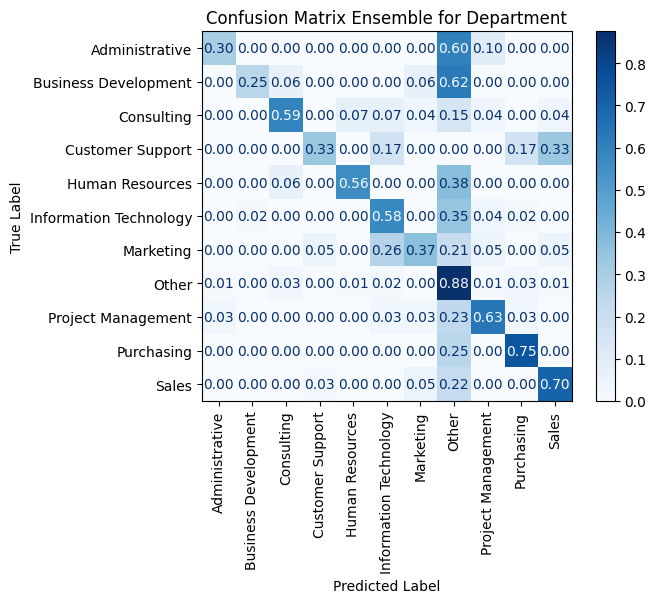

In [22]:
cm_norm = confusion_matrix(
    y_true,
    y_pred_ens,
    normalize="true"
)

plt.figure(figsize=(20, 20), dpi=600)

display = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=encoder.classes_)
display.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")

plt.title("Confusion Matrix Ensemble for Department")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("plots/cm_ensemble_department.png", bbox_inches="tight")
plt.show()

Compare with Huggingface model alone

In [23]:
y_pred_hf = np.array(model_hf.predict(X_texts), dtype=object)

print("HF Accuracy:", accuracy_score(y_true, y_pred_hf))
print("HF Macro F1:", f1_score(y_true, y_pred_hf, average="macro"))
print(classification_report(
    y_true, y_pred_hf,
    labels=enc_order, target_names=enc_order,
    zero_division=0
))


HF Accuracy: 0.7111597374179431
HF Macro F1: 0.5627161666512291
                        precision    recall  f1-score   support

        Administrative       0.43      0.30      0.35        10
  Business Development       0.57      0.25      0.35        16
            Consulting       0.62      0.59      0.60        27
      Customer Support       0.50      0.33      0.40         6
       Human Resources       0.69      0.56      0.62        16
Information Technology       0.71      0.56      0.62        52
             Marketing       0.58      0.37      0.45        19
                 Other       0.75      0.86      0.80       232
    Project Management       0.71      0.67      0.69        30
            Purchasing       0.45      0.75      0.56        12
                 Sales       0.76      0.70      0.73        37

              accuracy                           0.71       457
             macro avg       0.62      0.54      0.56       457
          weighted avg       0.71     